# Prediksi Tingkat Kesejahteraan Menggunakan Random Forest Classifier
**Algoritma:** Random Forest Classifier  
**Dataset:** Data Kesejahteraan yang telah dipreprocessing

## 1. Import Libraries

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 2. Load Dataset

In [100]:
df = pd.read_csv("../preprocessing/dataset_preprocessed.csv")

## 3. Exploratory Data Analysis (EDA)

In [101]:
df.head()

,jumlah_penduduk_miskin,jumlah_pengangguran_terbuka,pdrb_total_adhk,harapan_lama_sekolah,kesejahteraan,kesejahteraan_encoded
0,477200,686459,9.293200e+10,3,Sangat Sejahtera,1
1,249600,255889,2.860100e+10,3,Tidak Sejahtera,4
2,311000,302214,1.969700e+10,3,Sangat Tidak Sejahtera,2
3,296300,556729,4.843200e+10,3,Cukup,0
4,335600,295040,2.546500e+10,3,Sangat Tidak Sejahtera,2


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   jumlah_penduduk_miskin       405 non-null    int64  
 1   jumlah_pengangguran_terbuka  405 non-null    int64  
 2   pdrb_total_adhk              405 non-null    float64
 3   harapan_lama_sekolah         405 non-null    int64  
 4   kesejahteraan                405 non-null    object 
 5   kesejahteraan_encoded        405 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.1+ KB


In [103]:
df.describe()

,jumlah_penduduk_miskin,jumlah_pengangguran_terbuka,pdrb_total_adhk,harapan_lama_sekolah,kesejahteraan_encoded
count,405.000000,405.000000,4.050000e+02,405.000000,405.000000
mean,153530.864198,158534.158025,4.928217e+10,3.659259,1.896296
std,104329.140061,119288.444766,5.600873e+10,0.519372,1.287453
min,0.000000,8926.000000,2.026000e+09,1.000000,0.000000
25%,79200.000000,66803.000000,1.715600e+10,3.000000,1.000000
50%,141400.000000,141688.000000,2.781500e+10,4.000000,2.000000
75%,214600.000000,206336.000000,5.253400e+10,4.000000,2.000000
max,499100.000000,686459.000000,2.940000e+11,4.000000,4.000000


Distribusi Kelas Kesejahteraan:
kesejahteraan
Sangat Tidak Sejahtera    133
Sangat Sejahtera          122
Tidak Sejahtera            83
Cukup                      51
Sejahtera                  16
Name: count, dtype: int64


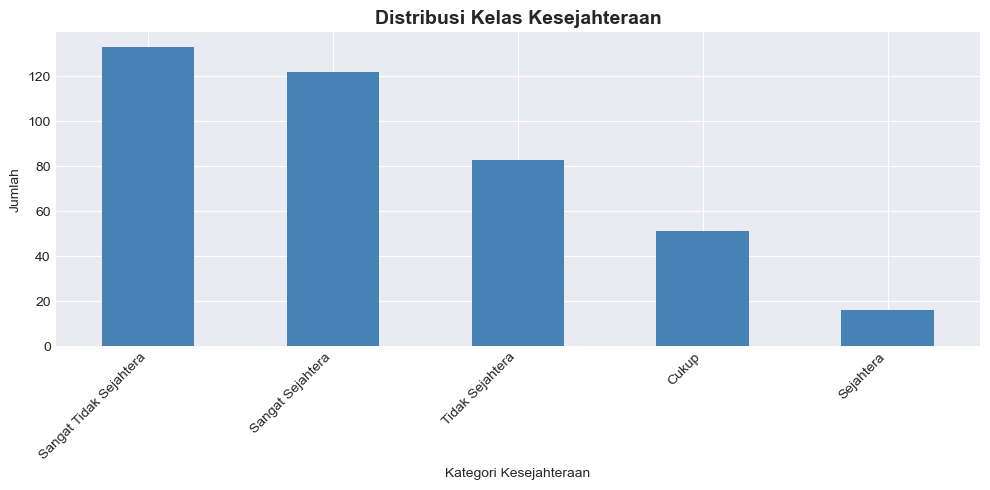

In [104]:
print("Distribusi Kelas Kesejahteraan:")
print(df['kesejahteraan'].value_counts())

# Visualisasi distribusi kelas
plt.figure(figsize=(10, 5))
df['kesejahteraan'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Distribusi Kelas Kesejahteraan', fontsize=14, fontweight='bold')
plt.xlabel('Kategori Kesejahteraan')
plt.ylabel('Jumlah')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Pemisahan Fitur dan Target

In [105]:
X = df[['jumlah_penduduk_miskin', 'jumlah_pengangguran_terbuka', 'pdrb_total_adhk', 'harapan_lama_sekolah']]
y = df['kesejahteraan_encoded']

print(f"Jumlah fitur: {X.shape[1]}")
print(f"Jumlah sampel: {X.shape[0]}")
print(f"\nFitur yang digunakan: {list(X.columns)}")

Jumlah fitur: 4
Jumlah sampel: 405

Fitur yang digunakan: ['jumlah_penduduk_miskin', 'jumlah_pengangguran_terbuka', 'pdrb_total_adhk', 'harapan_lama_sekolah']


## 5. Split Data (Training dan Testing)
Dataset dibagi menjadi 80% data training dan 20% data testing

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Data Training: {X_train.shape[0]} sampel")
print(f"Data Testing: {X_test.shape[0]} sampel")

Data Training: 324 sampel
Data Testing: 81 sampel


## 6. Training Model Random Forest Classifier

In [107]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_jobs=-1, random_state=42)

## 7. Evaluasi Model

In [108]:
# Prediksi pada data training
y_train_pred = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

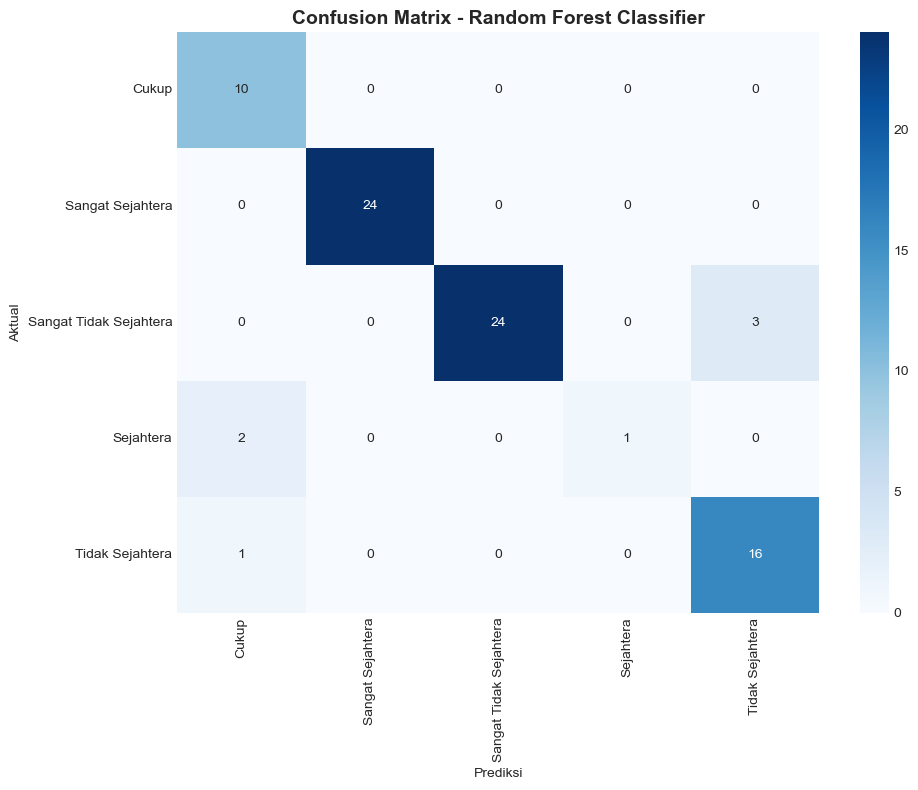

In [109]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(df['kesejahteraan'].unique()),
            yticklabels=sorted(df['kesejahteraan'].unique()))
plt.title('Confusion Matrix - Random Forest Classifier', fontsize=14, fontweight='bold')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.tight_layout()
plt.show()

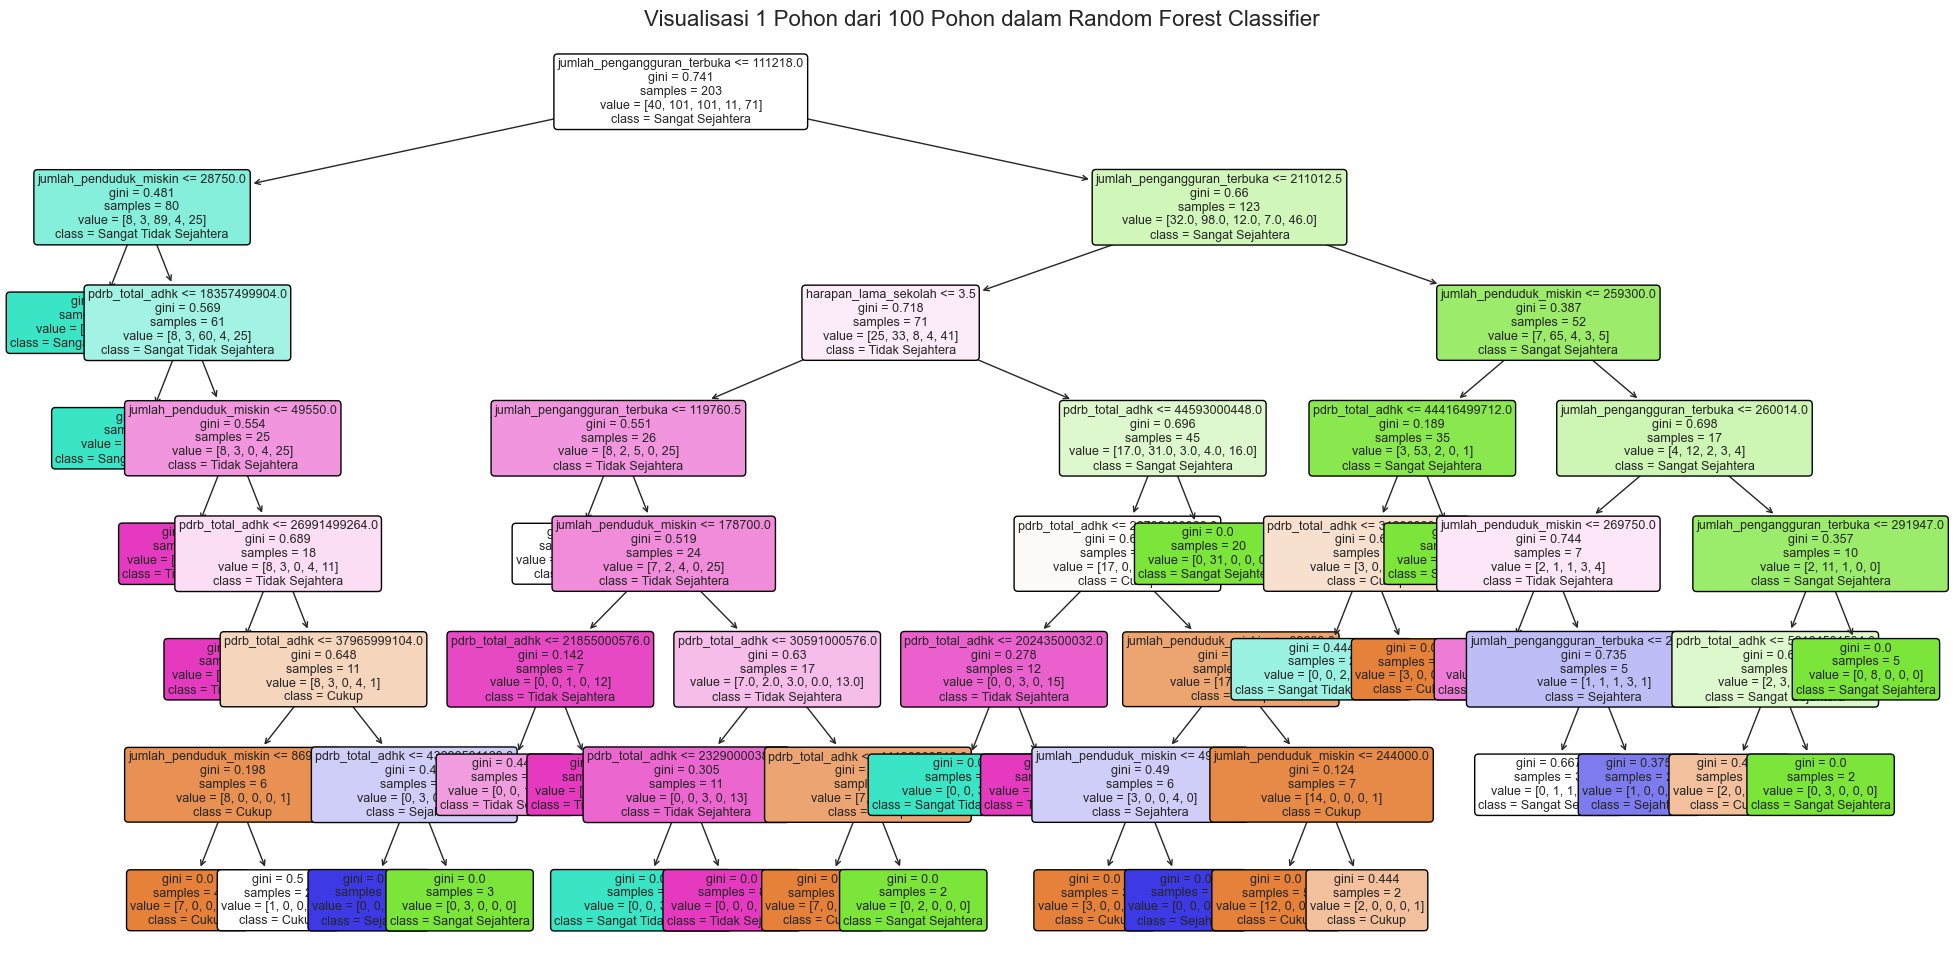

In [110]:
plt.figure(figsize=(24, 12))

sorted_class_names = df.sort_values('kesejahteraan_encoded')['kesejahteraan'].unique()

plot_tree(rf_model.estimators_[0], 
          feature_names=X.columns,
          class_names=sorted_class_names,
          filled=True, 
          rounded=True, 
          fontsize=9)

plt.title("Visualisasi 1 Pohon dari 100 Pohon dalam Random Forest Classifier", fontsize=16)
plt.show()

## 8. Feature Importance
Analisis pentingnya setiap fitur dalam model Random Forest

In [111]:
feature_importance = pd.DataFrame({
    'Fitur': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

Feature Importance:
                         Fitur  Importance
2              pdrb_total_adhk    0.720244
1  jumlah_pengangguran_terbuka    0.171708
0       jumlah_penduduk_miskin    0.093626
3         harapan_lama_sekolah    0.014421


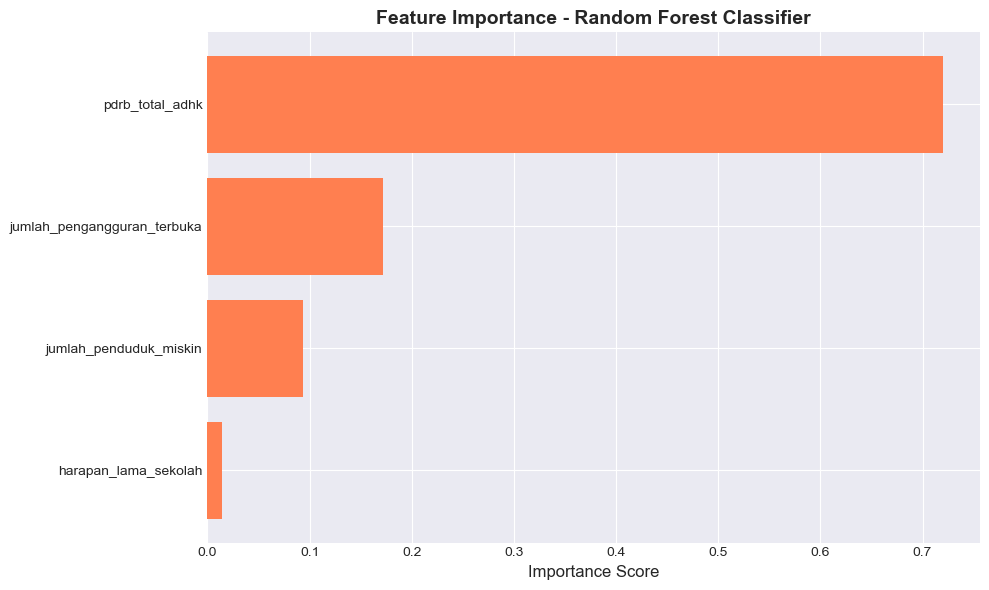

In [112]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Fitur'], feature_importance['Importance'], color='coral')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance - Random Forest Classifier', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 9. Visualisasi Decision Tree dari Random Forest

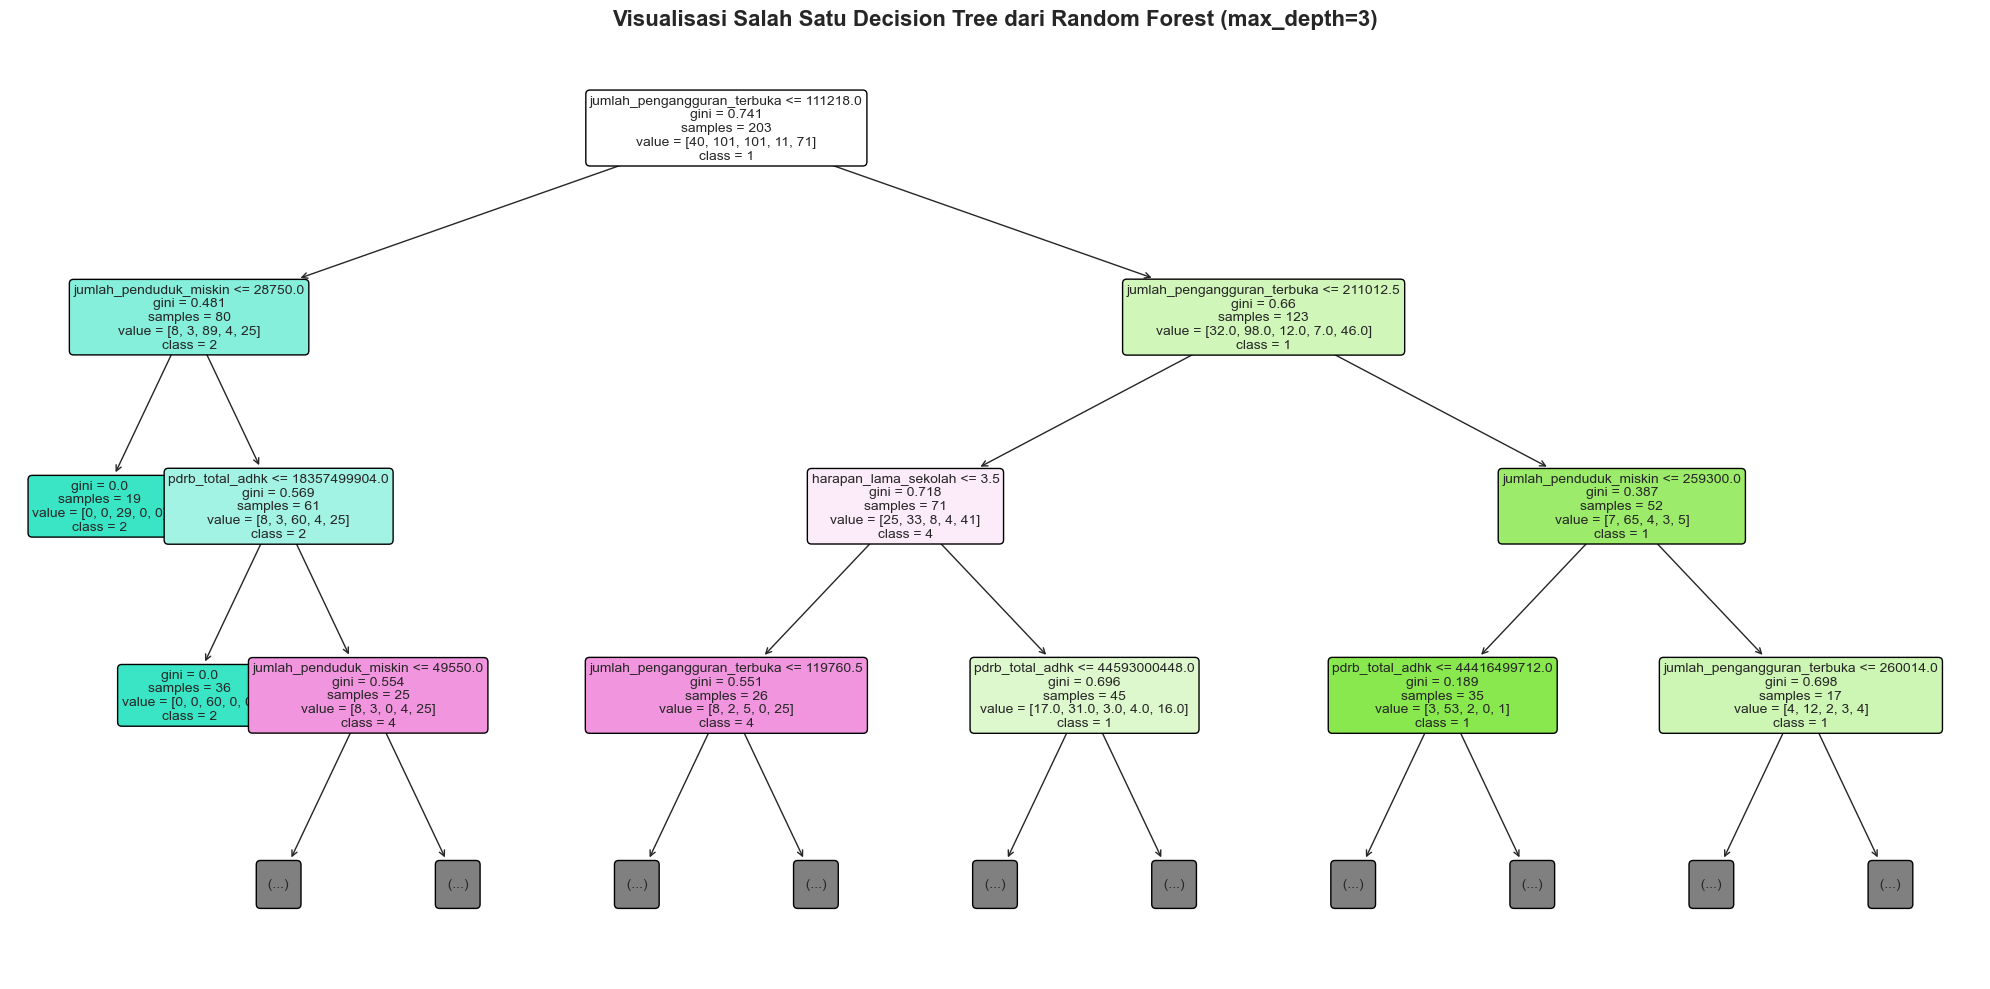

In [113]:
plt.figure(figsize=(20, 10))
plot_tree(
    rf_model.estimators_[0], 
    feature_names=X.columns,
    class_names=[str(c) for c in sorted(y.unique())],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3 
)
plt.title('Visualisasi Salah Satu Decision Tree dari Random Forest (max_depth=3)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Prediksi Data Baru (Contoh)

In [114]:
data_baru = pd.DataFrame({
    'jumlah_penduduk_miskin': [300000, 100000],
    'jumlah_pengangguran_terbuka': [400000, 150000],
    'pdrb_total_adhk': [50000000000, 150000000000],
    'harapan_lama_sekolah': [3, 4]
})

prediksi = rf_model.predict(data_baru)

label_mapping = df.groupby('kesejahteraan_encoded')['kesejahteraan'].first().to_dict()

print("\nHasil Prediksi Data Baru:")
print("="*70)
for i, pred in enumerate(prediksi):
    print(f"Data ke-{i+1}:")
    print(f"  - Jumlah Penduduk Miskin: {data_baru.iloc[i]['jumlah_penduduk_miskin']:,}")
    print(f"  - Jumlah Pengangguran Terbuka: {data_baru.iloc[i]['jumlah_pengangguran_terbuka']:,}")
    print(f"  - PDRB Total ADHK: Rp {data_baru.iloc[i]['pdrb_total_adhk']:,.0f}")
    print(f"  - Harapan Lama Sekolah: {data_baru.iloc[i]['harapan_lama_sekolah']} tahun")
    print(f"  → Prediksi: {label_mapping[pred]}")
    print("-"*70)


Hasil Prediksi Data Baru:
Data ke-1:
  - Jumlah Penduduk Miskin: 300,000
  - Jumlah Pengangguran Terbuka: 400,000
  - PDRB Total ADHK: Rp 50,000,000,000
  - Harapan Lama Sekolah: 3 tahun
  → Prediksi: Sangat Sejahtera
----------------------------------------------------------------------
Data ke-2:
  - Jumlah Penduduk Miskin: 100,000
  - Jumlah Pengangguran Terbuka: 150,000
  - PDRB Total ADHK: Rp 150,000,000,000
  - Harapan Lama Sekolah: 4 tahun
  → Prediksi: Sangat Sejahtera
----------------------------------------------------------------------


## Kesimpulan

Model Random Forest Classifier telah berhasil dibangun untuk memprediksi tingkat kesejahteraan berdasarkan 4 fitur utama:
1. Jumlah Penduduk Miskin
2. Jumlah Pengangguran Terbuka
3. PDRB Total ADHK
4. Harapan Lama Sekolah

**Kelebihan Random Forest:**
- Robust terhadap overfitting karena menggunakan ensemble dari banyak pohon
- Dapat menangani data non-linear dengan baik
- Memberikan feature importance untuk interpretasi model
- Tidak memerlukan normalisasi data

**Parameter yang digunakan:**
- n_estimators: 100 (jumlah pohon)
- max_depth: 10 (kedalaman maksimal pohon)
- min_samples_split: 5
- min_samples_leaf: 2